# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from ddpg_agent import Agent, load_and_run
from collections import deque
import torch



cuda:0


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Define the Learning Process with Deep Deterministic  Policy Gradient Method


The learning process using the Deep Deterministic Policy Gradient method is defined below (ddpg). The input parameters are described in the comments below. The outputs are list of the maximum scores for each episode and a list of the maimum scores averaged over the current and preceding 99 episodes (100-episode averages). The episodes before 100 just have averages over the preceding scores although there are less than 100.

In [5]:

def ddpg(
    agent,
    n_episodes=2000,
    max_t=1500,
    print_every=100,
    gamma_initial = 0.9,
    gamma_final = 0.99,
    gamma_rate = 0.002,
    tau_initial = 0.02,
    tau_final = 0.001,
    tau_rate = 0.001,
    noise_factor = 1.0
):
    """
    Reinforcement learning with Deep Deterministic Policy Gradients
    n_episodes (int): Maximum number of training episodes
    max_t (int): Maximum number of timesteps per episode
    epsilon_initial (float): Initial value of epsilon for epsilon-greedy selection of an action
    epsilon_final (float): Final value of epsilon
    epsilon_rate (float): A rate (0.0 to 1.0) for decreasing epsilon for each episode. Higher is faster decay.
    gamma_initial (float): Initial gamma discount factor (0 to 1). Higher values favor long term over current rewards.
    gamma_final (float): Final gamma discount factor (0 to 1).
    gammma_rate (float): A rate (0 to 1) for increasing gamma.
    beta_initial (float): For prioritized replay. Corrects bias induced by weighted sampling of stored experiences.
        The beta parameters have no effect if the agent has prioritized experience replay activated.
    beta_rate (float): Rate (0 to 1) for increasing beta to 1 as per Schauel et al. https://arxiv.org/abs/1511.05952
    tau_initial (float): Initial value for tau, the weighting factor for soft updating the neural network.
        The tau parameters have no effect if the agent uses fixed Q targets instead of soft updating.
    tau_final (float): Final value of tau.
    tau_rate (float): Rate (0 to 1) for increasing tau each episode.
    
    Returned values:
        max_scores[]: The maximum scores for each episode.
        avg_max_scores[]: The maximum scores averaged over the maximum score for the current episode and the preceding
            99 episodes (100-episode averages).
    
    """
    
    gamma = gamma_initial
    gamma_scale = 1.0 - gamma_rate
    
    tau = tau_initial
    tau_scale = 1.0 - tau_rate
    
    noise_scale = 1.0
    
    success = False
    first05 = False
    both05 = False
    both1 = False
    
    max_scores_deque = deque(maxlen = print_every)
    #scores_deque = deque(maxlen=print_every)
    #scores = []
    max_scores = []
    avg_max_scores = []
    best_avg_max = 0.0
    best_agent_max = 0.0
    for i_episode in range(1, n_episodes+1):
        
        # Reset environment
        env_info = env.reset(train_mode=True)[brain_name]
        
        # Get next state
        state = env_info.vector_observations
        
        # state = env.reset()
        agent.reset()

        score = np.zeros(agent.num_agents)
        
        for t in range(max_t):
            
            # Get actions
            action = agent.act(state, noise_scale)
            #print(action)

            # Send actions to the environment
            env_info = env.step(action)[brain_name]
            
            # Get next state
            next_state = env_info.vector_observations
            
            # Get rewards
            reward = env_info.rewards
            
            # Check if episode is finished
            done = env_info.local_done
            
            # Make the agent proceed to the next timestep in the environment
            agent.step(state, action, reward, next_state, done, gamma, tau)
            
            # Add rewards to scores
            score += reward
            
            # Replace the current state with the next state for the next episode
            state = next_state
            
            # Exit if episode is finished
            if np.any(done):
                break
                
        #print('Total score (averaged over agents) this episode: {}'.format(np.mean(score)))
        agent_avg = np.mean(score)
        agent_max = np.max(score)
        agent_min = np.min(score)
        max_scores.append(agent_max)
        max_scores_deque.append(agent_max)         
        avg_max = np.mean(max_scores_deque)
        avg_max_scores.append(avg_max)
        #scores_deque.append(agent_avg)
        #scores.append(agent_avg)
        avg_score = np.mean(max_scores_deque)
                          
        print('Ep {}\tEp AvgMax: {:.4f}\tAg1: {:.4f}\tAg2: {:.4f}\tMax: {:.4f}\tg: {:.4f}\tns: {:.4f}\ttau: {:.4f}'.format(
            i_episode, avg_max, score[0], score[1], agent_max, gamma, noise_scale, tau))
        if not first05 and agent_max > 0.5:
            first05 = True
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_first.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_first.pth')
            print("Agent max score >0.5 after {:d} episodes.".format(i_episode))
        if not both05 and score[0] > 0.5 and score[1] > 0.5:
            both05 = True
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_both05.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_both05.pth')
            print("Both agents score >0.5 after {:d} episodes.".format(i_episode))
        if not both1 and score[0] > 1.0 and score[1] > 1.0:
            both1 = True
            best_agent_max = agent_max
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_both1.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_both1.pth')
            print("Both agents score >1 after {:d} episodes.".format(i_episode))
        if i_episode >=100 and not success and avg_max > 0.5:
            success = True
            best_avg_max = avg_max
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print("100-episode-average max score >0.5 after {:d} episodes.".format(i_episode))
        if success and avg_max > best_avg_max:
            best_avg_max = avg_max
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_best_avg_max.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_best_avg_max.pth')
            print("New best 100-episode-average at Episode {:d}.".format(i_episode))
        if both1 and agent_max > best_agent_max:
            best_agent_max = agent_max
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_best_agent_max.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_best_agent_max.pth')
            print("New best agent maximum score at Episode {:d}.".format(i_episode))
                
        # Increase gamma discount factor. Limit to gamma_final.
        gamma = gamma_final - gamma_scale * (gamma_final - gamma)
        
        tau = tau_final - tau_scale * (tau_final - tau)
        
        noise_scale *= noise_factor

    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_final.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_final.pth')
    return max_scores, avg_max_scores


## 4. Declare the Learning Agent

Agent has the following parameters:

    state_size: Number of parameters defining the environment state
    action_size: Number of pameters defining the actions
    num_agents: Number of learning agents
    random_seed: Random seed number
    batch_size: Batch size for neural network training
    lr_actor: Learning rate for the actor neural network
    lr_critic: Learning rate for the critic neural network
    noise_theta (float): theta for Ornstein-Uhlenbeck noise process
    noise_sigma (float): sigma for Ornstein-Uhlenbeck noise process
    actor_fc1 (int): Number of hidden units in the first fully connected layer of the actor network
    actor_fc2: Units in second layer
    actor_fc3: Units in third fully connected layer. This parameter does nothing for the "RELU" network
    critic_fc1: Number of hidden units in the first fully connected layer of the critic network
    critic_fc2: Units in second layer
    critic_fc3: Units in third layer. This parameter does nothing for the "RELU" network
    update_every: The number of time steps between each updating of the neural networks 
    num_updates: The number of times to update the networks at every update_every interval
    buffer_size: Buffer size for experience replay. Default 2e6.
    network (string): The name of the neural networks that are used for learning.
        There are only 2 choices, one with only 2 fully connected layers and RELU activations and one
        with 3 fully connected layers with SELU activations.
        Their names are "RELU" and "SELU," respectively. Default is "RELU."


In [6]:
agent = Agent(
    state_size = state_size,
    action_size = action_size,
    num_agents = num_agents,
    random_seed = 0,
    batch_size = 1024, 
    lr_actor = 0.001,
    lr_critic = 0.001,
    noise_theta = 0.1,
    noise_sigma = 0.05,
    actor_fc1 = 128,
    actor_fc2 = 128,
    critic_fc1 = 128,
    critic_fc2 = 128,
    update_every = 20,
    num_updates = 15,
    buffer_size = int(2e6)
)


## 5. Train the Agent

Perform the training and collect the scores. The following are printed for every episode:

    Ep: The episode number
    Ep AvgMax: The agent-maximum score averaged over the current episode and and previous 99 episodes.
    Ag1: The score for the first agent for the current episode
    Ag2: The score for the second agent.
    Max: The maximum of the 2 scores
    g: The gamma discount factor for the current episode.
    ns: The noise scaling factor for the current episode.
    tau: The weight factor used for soft updating for the current episode.
    
    Messages will appear to notify the user when various achievements occur:
        1. First time achieving an agent maximum score of 0.5
        2. First time both agents score >0.5
        3. First time both agents score >1
        3. Each time a new best agent-maximum score is achieved (after achievement 3)
        4. First time the 100-episode-average maximum score >0.5 (after at least 100 episodes)
        5. Each time a new best 100-episode-average maximum score is achieved (after achievement 4)
        
        A checkpoint is saved at each of these notifications. The checkpoints are overwritten for 3 and 5.

In [7]:
max_scores, avg_max_scores = ddpg(
    agent,
    n_episodes = 2000,
    max_t = 10000,
    gamma_initial = 0.95,
    gamma_final = 0.99,
    gamma_rate = 0.01,
    tau_initial = 0.01,
    tau_final = 0.001,
    tau_rate = 0.001,
    noise_factor = 0.9999
)


Ep 1	Ep AvgMax: 0.0000	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9500	ns: 1.0000	tau: 0.0100
Ep 2	Ep AvgMax: 0.0000	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9504	ns: 0.9999	tau: 0.0100
Ep 3	Ep AvgMax: 0.0000	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9508	ns: 0.9998	tau: 0.0100
Ep 4	Ep AvgMax: 0.0000	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9512	ns: 0.9997	tau: 0.0100
Ep 5	Ep AvgMax: 0.0000	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9516	ns: 0.9996	tau: 0.0100
Ep 6	Ep AvgMax: 0.0000	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9520	ns: 0.9995	tau: 0.0100
Ep 7	Ep AvgMax: 0.0000	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9523	ns: 0.9994	tau: 0.0099
Ep 8	Ep AvgMax: 0.0000	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9527	ns: 0.9993	tau: 0.0099
Ep 9	Ep AvgMax: 0.0000	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9531	ns: 0.9992	tau: 0.0099
Ep 10	Ep AvgMax: 0.0000	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9535	ns: 0.9991	tau: 0.0099
Ep 11	Ep AvgMax: 0.0000	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.953

Ep 92	Ep AvgMax: 0.0052	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9740	ns: 0.9909	tau: 0.0092
Ep 93	Ep AvgMax: 0.0052	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9741	ns: 0.9908	tau: 0.0092
Ep 94	Ep AvgMax: 0.0051	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9743	ns: 0.9907	tau: 0.0092
Ep 95	Ep AvgMax: 0.0051	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9744	ns: 0.9906	tau: 0.0092
Ep 96	Ep AvgMax: 0.0050	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9746	ns: 0.9905	tau: 0.0092
Ep 97	Ep AvgMax: 0.0049	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9748	ns: 0.9904	tau: 0.0092
Ep 98	Ep AvgMax: 0.0049	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9749	ns: 0.9903	tau: 0.0092
Ep 99	Ep AvgMax: 0.0048	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9751	ns: 0.9902	tau: 0.0092
Ep 100	Ep AvgMax: 0.0057	Ag1: 0.0000	Ag2: 0.0900	Max: 0.0900	g: 0.9752	ns: 0.9901	tau: 0.0092
Ep 101	Ep AvgMax: 0.0057	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9754	ns: 0.9900	tau: 0.0091
Ep 102	Ep AvgMax: 0.0057	Ag1: 0.0000	Ag2: -0.0100	Max: 0.00

Ep 181	Ep AvgMax: 0.0047	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9834	ns: 0.9822	tau: 0.0085
Ep 182	Ep AvgMax: 0.0047	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9835	ns: 0.9821	tau: 0.0085
Ep 183	Ep AvgMax: 0.0047	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9836	ns: 0.9820	tau: 0.0085
Ep 184	Ep AvgMax: 0.0047	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9836	ns: 0.9819	tau: 0.0085
Ep 185	Ep AvgMax: 0.0047	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9837	ns: 0.9818	tau: 0.0085
Ep 186	Ep AvgMax: 0.0047	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9838	ns: 0.9817	tau: 0.0085
Ep 187	Ep AvgMax: 0.0047	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9838	ns: 0.9816	tau: 0.0085
Ep 188	Ep AvgMax: 0.0047	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9839	ns: 0.9815	tau: 0.0085
Ep 189	Ep AvgMax: 0.0047	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9840	ns: 0.9814	tau: 0.0085
Ep 190	Ep AvgMax: 0.0047	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9840	ns: 0.9813	tau: 0.0084
Ep 191	Ep AvgMax: 0.0047	Ag1: 0.0000	Ag2: -0.0100	

Ep 271	Ep AvgMax: 0.0030	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9873	ns: 0.9734	tau: 0.0079
Ep 272	Ep AvgMax: 0.0030	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9874	ns: 0.9733	tau: 0.0079
Ep 273	Ep AvgMax: 0.0030	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9874	ns: 0.9732	tau: 0.0079
Ep 274	Ep AvgMax: 0.0030	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9874	ns: 0.9731	tau: 0.0078
Ep 275	Ep AvgMax: 0.0030	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9875	ns: 0.9730	tau: 0.0078
Ep 276	Ep AvgMax: 0.0030	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9875	ns: 0.9729	tau: 0.0078
Ep 277	Ep AvgMax: 0.0030	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9875	ns: 0.9728	tau: 0.0078
Ep 278	Ep AvgMax: 0.0030	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9875	ns: 0.9727	tau: 0.0078
Ep 279	Ep AvgMax: 0.0030	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9876	ns: 0.9726	tau: 0.0078
Ep 280	Ep AvgMax: 0.0030	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9876	ns: 0.9725	tau: 0.0078
Ep 281	Ep AvgMax: 0.0030	Ag1: -0.0100	Ag2: 0.0000	

Ep 358	Ep AvgMax: 0.0050	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9889	ns: 0.9649	tau: 0.0073
Ep 359	Ep AvgMax: 0.0050	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9889	ns: 0.9648	tau: 0.0073
Ep 360	Ep AvgMax: 0.0050	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9889	ns: 0.9647	tau: 0.0073
Ep 361	Ep AvgMax: 0.0050	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9889	ns: 0.9646	tau: 0.0073
Ep 362	Ep AvgMax: 0.0050	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9889	ns: 0.9645	tau: 0.0073
Ep 363	Ep AvgMax: 0.0050	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9889	ns: 0.9644	tau: 0.0073
Ep 364	Ep AvgMax: 0.0050	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9890	ns: 0.9643	tau: 0.0073
Ep 365	Ep AvgMax: 0.0050	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9890	ns: 0.9643	tau: 0.0073
Ep 366	Ep AvgMax: 0.0050	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9890	ns: 0.9642	tau: 0.0072
Ep 367	Ep AvgMax: 0.0050	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9890	ns: 0.9641	tau: 0.0072
Ep 368	Ep AvgMax: 0.0050	Ag1: -0.0100	Ag2: 0.0000	

Ep 445	Ep AvgMax: 0.0079	Ag1: 0.1000	Ag2: -0.0100	Max: 0.1000	g: 0.9895	ns: 0.9566	tau: 0.0068
Ep 446	Ep AvgMax: 0.0079	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9895	ns: 0.9565	tau: 0.0068
Ep 447	Ep AvgMax: 0.0079	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9895	ns: 0.9564	tau: 0.0068
Ep 448	Ep AvgMax: 0.0079	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9896	ns: 0.9563	tau: 0.0068
Ep 449	Ep AvgMax: 0.0089	Ag1: -0.0100	Ag2: 0.1000	Max: 0.1000	g: 0.9896	ns: 0.9562	tau: 0.0067
Ep 450	Ep AvgMax: 0.0089	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9896	ns: 0.9561	tau: 0.0067
Ep 451	Ep AvgMax: 0.0089	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9896	ns: 0.9560	tau: 0.0067
Ep 452	Ep AvgMax: 0.0099	Ag1: 0.1000	Ag2: -0.0100	Max: 0.1000	g: 0.9896	ns: 0.9559	tau: 0.0067
Ep 453	Ep AvgMax: 0.0099	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9896	ns: 0.9558	tau: 0.0067
Ep 454	Ep AvgMax: 0.0099	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9896	ns: 0.9557	tau: 0.0067
Ep 455	Ep AvgMax: 0.0109	Ag1: -0.0100	Ag2: 0.1000	

Ep 532	Ep AvgMax: 0.0642	Ag1: 0.2000	Ag2: 0.0900	Max: 0.2000	g: 0.9898	ns: 0.9483	tau: 0.0063
Ep 533	Ep AvgMax: 0.0652	Ag1: 0.1000	Ag2: -0.0100	Max: 0.1000	g: 0.9898	ns: 0.9482	tau: 0.0063
Ep 534	Ep AvgMax: 0.0662	Ag1: 0.1000	Ag2: -0.0100	Max: 0.1000	g: 0.9898	ns: 0.9481	tau: 0.0063
Ep 535	Ep AvgMax: 0.0672	Ag1: 0.1000	Ag2: 0.0900	Max: 0.1000	g: 0.9898	ns: 0.9480	tau: 0.0063
Ep 536	Ep AvgMax: 0.0682	Ag1: 0.1000	Ag2: -0.0100	Max: 0.1000	g: 0.9898	ns: 0.9479	tau: 0.0063
Ep 537	Ep AvgMax: 0.0691	Ag1: 0.0000	Ag2: 0.0900	Max: 0.0900	g: 0.9898	ns: 0.9478	tau: 0.0063
Ep 538	Ep AvgMax: 0.0701	Ag1: -0.0100	Ag2: 0.1000	Max: 0.1000	g: 0.9898	ns: 0.9477	tau: 0.0063
Ep 539	Ep AvgMax: 0.0721	Ag1: 0.2000	Ag2: 0.1900	Max: 0.2000	g: 0.9898	ns: 0.9476	tau: 0.0063
Ep 540	Ep AvgMax: 0.0721	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9898	ns: 0.9475	tau: 0.0062
Ep 541	Ep AvgMax: 0.0721	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9898	ns: 0.9474	tau: 0.0062
Ep 542	Ep AvgMax: 0.0731	Ag1: -0.0100	Ag2: 0.1000	Max:

Ep 619	Ep AvgMax: 0.0953	Ag1: 0.0900	Ag2: 0.2000	Max: 0.2000	g: 0.9899	ns: 0.9401	tau: 0.0058
Ep 620	Ep AvgMax: 0.0943	Ag1: -0.0100	Ag2: 0.1000	Max: 0.1000	g: 0.9899	ns: 0.9400	tau: 0.0058
Ep 621	Ep AvgMax: 0.0943	Ag1: -0.0100	Ag2: 0.1000	Max: 0.1000	g: 0.9899	ns: 0.9399	tau: 0.0058
Ep 622	Ep AvgMax: 0.0953	Ag1: 0.0900	Ag2: 0.1000	Max: 0.1000	g: 0.9899	ns: 0.9398	tau: 0.0058
Ep 623	Ep AvgMax: 0.0953	Ag1: -0.0100	Ag2: 0.1000	Max: 0.1000	g: 0.9899	ns: 0.9397	tau: 0.0058
Ep 624	Ep AvgMax: 0.0953	Ag1: 0.0900	Ag2: 0.1000	Max: 0.1000	g: 0.9899	ns: 0.9396	tau: 0.0058
Ep 625	Ep AvgMax: 0.0953	Ag1: -0.0100	Ag2: 0.1000	Max: 0.1000	g: 0.9899	ns: 0.9395	tau: 0.0058
Ep 626	Ep AvgMax: 0.0953	Ag1: 0.1000	Ag2: -0.0100	Max: 0.1000	g: 0.9899	ns: 0.9394	tau: 0.0058
Ep 627	Ep AvgMax: 0.0953	Ag1: 0.0900	Ag2: 0.1000	Max: 0.1000	g: 0.9899	ns: 0.9393	tau: 0.0058
Ep 628	Ep AvgMax: 0.0953	Ag1: 0.1000	Ag2: 0.0900	Max: 0.1000	g: 0.9899	ns: 0.9392	tau: 0.0058
Ep 629	Ep AvgMax: 0.0963	Ag1: 0.2000	Ag2: 0.0900	Max: 0

Ep 706	Ep AvgMax: 0.1007	Ag1: 0.0000	Ag2: 0.0900	Max: 0.0900	g: 0.9900	ns: 0.9319	tau: 0.0054
Ep 707	Ep AvgMax: 0.0996	Ag1: 0.0000	Ag2: 0.0900	Max: 0.0900	g: 0.9900	ns: 0.9318	tau: 0.0054
Ep 708	Ep AvgMax: 0.1015	Ag1: 0.1000	Ag2: 0.1900	Max: 0.1900	g: 0.9900	ns: 0.9317	tau: 0.0054
Ep 709	Ep AvgMax: 0.1015	Ag1: -0.0100	Ag2: 0.1000	Max: 0.1000	g: 0.9900	ns: 0.9316	tau: 0.0054
Ep 710	Ep AvgMax: 0.1014	Ag1: 0.0000	Ag2: 0.0900	Max: 0.0900	g: 0.9900	ns: 0.9316	tau: 0.0054
Ep 711	Ep AvgMax: 0.1014	Ag1: 0.1900	Ag2: 0.3000	Max: 0.3000	g: 0.9900	ns: 0.9315	tau: 0.0054
Ep 712	Ep AvgMax: 0.1014	Ag1: 0.1000	Ag2: 0.0900	Max: 0.1000	g: 0.9900	ns: 0.9314	tau: 0.0054
Ep 713	Ep AvgMax: 0.1014	Ag1: 0.0900	Ag2: 0.1000	Max: 0.1000	g: 0.9900	ns: 0.9313	tau: 0.0054
Ep 714	Ep AvgMax: 0.1034	Ag1: 0.0900	Ag2: 0.2000	Max: 0.2000	g: 0.9900	ns: 0.9312	tau: 0.0054
Ep 715	Ep AvgMax: 0.1054	Ag1: 0.2000	Ag2: 0.0900	Max: 0.2000	g: 0.9900	ns: 0.9311	tau: 0.0054
Ep 716	Ep AvgMax: 0.1054	Ag1: 0.1000	Ag2: -0.0100	Max: 0.10

Ep 792	Ep AvgMax: 0.4329	Ag1: 2.2000	Ag2: 2.0900	Max: 2.2000	g: 0.9900	ns: 0.9239	tau: 0.0051
Ep 793	Ep AvgMax: 0.4480	Ag1: 1.6000	Ag2: 1.4900	Max: 1.6000	g: 0.9900	ns: 0.9239	tau: 0.0051
Ep 794	Ep AvgMax: 0.4570	Ag1: 0.8900	Ag2: 1.0000	Max: 1.0000	g: 0.9900	ns: 0.9238	tau: 0.0051
Ep 795	Ep AvgMax: 0.4581	Ag1: 0.0900	Ag2: 0.2000	Max: 0.2000	g: 0.9900	ns: 0.9237	tau: 0.0051
Ep 796	Ep AvgMax: 0.4622	Ag1: 0.5000	Ag2: 0.4900	Max: 0.5000	g: 0.9900	ns: 0.9236	tau: 0.0051
Ep 797	Ep AvgMax: 0.4692	Ag1: 0.7000	Ag2: 0.6900	Max: 0.7000	g: 0.9900	ns: 0.9235	tau: 0.0051
Ep 798	Ep AvgMax: 0.4762	Ag1: 0.8000	Ag2: 0.6900	Max: 0.8000	g: 0.9900	ns: 0.9234	tau: 0.0051
Ep 799	Ep AvgMax: 0.4772	Ag1: 0.0900	Ag2: 0.2000	Max: 0.2000	g: 0.9900	ns: 0.9233	tau: 0.0051
Ep 800	Ep AvgMax: 0.4842	Ag1: 0.7900	Ag2: 0.8000	Max: 0.8000	g: 0.9900	ns: 0.9232	tau: 0.0050
Ep 801	Ep AvgMax: 0.5002	Ag1: 1.7000	Ag2: 1.6900	Max: 1.7000	g: 0.9900	ns: 0.9231	tau: 0.0050
100-episode-average max score >0.5 after 801 episodes.
Ep 80

Ep 855	Ep AvgMax: 0.9774	Ag1: 0.3900	Ag2: 0.5000	Max: 0.5000	g: 0.9900	ns: 0.9181	tau: 0.0048
New best 100-episode-average at Episode 855.
Ep 856	Ep AvgMax: 0.9814	Ag1: 0.7000	Ag2: 0.6900	Max: 0.7000	g: 0.9900	ns: 0.9180	tau: 0.0048
New best 100-episode-average at Episode 856.
Ep 857	Ep AvgMax: 0.9844	Ag1: 1.0000	Ag2: 0.9900	Max: 1.0000	g: 0.9900	ns: 0.9180	tau: 0.0048
New best 100-episode-average at Episode 857.
Ep 858	Ep AvgMax: 0.9844	Ag1: 0.4000	Ag2: 0.1900	Max: 0.4000	g: 0.9900	ns: 0.9179	tau: 0.0048
Ep 859	Ep AvgMax: 0.9734	Ag1: 0.7000	Ag2: 0.5900	Max: 0.7000	g: 0.9900	ns: 0.9178	tau: 0.0048
Ep 860	Ep AvgMax: 0.9844	Ag1: 1.2000	Ag2: 1.1900	Max: 1.2000	g: 0.9900	ns: 0.9177	tau: 0.0048
Ep 861	Ep AvgMax: 1.0094	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.9176	tau: 0.0048
New best 100-episode-average at Episode 861.
Ep 862	Ep AvgMax: 1.0204	Ag1: 1.6000	Ag2: 1.5900	Max: 1.6000	g: 0.9900	ns: 0.9175	tau: 0.0048
New best 100-episode-average at Episode 862.
Ep 863	Ep AvgMax: 1.019

Ep 938	Ep AvgMax: 0.7850	Ag1: 0.2000	Ag2: 0.0900	Max: 0.2000	g: 0.9900	ns: 0.9106	tau: 0.0045
Ep 939	Ep AvgMax: 0.7610	Ag1: 0.2000	Ag2: 0.1900	Max: 0.2000	g: 0.9900	ns: 0.9105	tau: 0.0045
Ep 940	Ep AvgMax: 0.7590	Ag1: 0.9000	Ag2: 0.7900	Max: 0.9000	g: 0.9900	ns: 0.9104	tau: 0.0045
Ep 941	Ep AvgMax: 0.7670	Ag1: 1.6900	Ag2: 1.7000	Max: 1.7000	g: 0.9900	ns: 0.9103	tau: 0.0045
Ep 942	Ep AvgMax: 0.7540	Ag1: 1.3900	Ag2: 1.4000	Max: 1.4000	g: 0.9900	ns: 0.9102	tau: 0.0045
Ep 943	Ep AvgMax: 0.7670	Ag1: 2.1000	Ag2: 1.9900	Max: 2.1000	g: 0.9900	ns: 0.9101	tau: 0.0045
Ep 944	Ep AvgMax: 0.7440	Ag1: 0.1000	Ag2: 0.0900	Max: 0.1000	g: 0.9900	ns: 0.9100	tau: 0.0045
Ep 945	Ep AvgMax: 0.7590	Ag1: 2.0000	Ag2: 1.9900	Max: 2.0000	g: 0.9900	ns: 0.9099	tau: 0.0045
Ep 946	Ep AvgMax: 0.7590	Ag1: 0.3000	Ag2: 0.1900	Max: 0.3000	g: 0.9900	ns: 0.9098	tau: 0.0045
Ep 947	Ep AvgMax: 0.7400	Ag1: 0.7000	Ag2: 0.6900	Max: 0.7000	g: 0.9900	ns: 0.9097	tau: 0.0045
Ep 948	Ep AvgMax: 0.7470	Ag1: 1.9900	Ag2: 2.0000	Max: 2.0000

Ep 1017	Ep AvgMax: 1.3115	Ag1: 0.5000	Ag2: 0.3900	Max: 0.5000	g: 0.9900	ns: 0.9034	tau: 0.0043
Ep 1018	Ep AvgMax: 1.3095	Ag1: 0.1900	Ag2: 0.2000	Max: 0.2000	g: 0.9900	ns: 0.9033	tau: 0.0043
Ep 1019	Ep AvgMax: 1.3075	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9900	ns: 0.9032	tau: 0.0043
Ep 1020	Ep AvgMax: 1.3295	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.9031	tau: 0.0042
New best 100-episode-average at Episode 1020.
Ep 1021	Ep AvgMax: 1.3285	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9900	ns: 0.9030	tau: 0.0042
Ep 1022	Ep AvgMax: 1.3435	Ag1: 1.5900	Ag2: 1.6000	Max: 1.6000	g: 0.9900	ns: 0.9029	tau: 0.0042
New best 100-episode-average at Episode 1022.
Ep 1023	Ep AvgMax: 1.3595	Ag1: 1.8900	Ag2: 1.9000	Max: 1.9000	g: 0.9900	ns: 0.9028	tau: 0.0042
New best 100-episode-average at Episode 1023.
Ep 1024	Ep AvgMax: 1.3764	Ag1: 1.7900	Ag2: 1.6000	Max: 1.7900	g: 0.9900	ns: 0.9028	tau: 0.0042
New best 100-episode-average at Episode 1024.
Ep 1025	Ep AvgMax: 1.4004	Ag1: 2.6000	Ag2: 2.4900	Max:

Ep 1087	Ep AvgMax: 1.7994	Ag1: 2.4900	Ag2: 2.5000	Max: 2.5000	g: 0.9900	ns: 0.8971	tau: 0.0040
Ep 1088	Ep AvgMax: 1.7994	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8970	tau: 0.0040
Ep 1089	Ep AvgMax: 1.7964	Ag1: 2.4000	Ag2: 2.3900	Max: 2.4000	g: 0.9900	ns: 0.8969	tau: 0.0040
Ep 1090	Ep AvgMax: 1.7964	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8968	tau: 0.0040
Ep 1091	Ep AvgMax: 1.7954	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8967	tau: 0.0040
Ep 1092	Ep AvgMax: 1.7965	Ag1: 0.6900	Ag2: 0.8000	Max: 0.8000	g: 0.9900	ns: 0.8966	tau: 0.0040
Ep 1093	Ep AvgMax: 1.8165	Ag1: 2.2900	Ag2: 2.3000	Max: 2.3000	g: 0.9900	ns: 0.8965	tau: 0.0040
Ep 1094	Ep AvgMax: 1.8295	Ag1: 2.6000	Ag2: 2.5000	Max: 2.6000	g: 0.9900	ns: 0.8965	tau: 0.0040
Ep 1095	Ep AvgMax: 1.8375	Ag1: 2.6000	Ag2: 2.7000	Max: 2.7000	g: 0.9900	ns: 0.8964	tau: 0.0040
New best 100-episode-average at Episode 1095.
Ep 1096	Ep AvgMax: 1.8315	Ag1: 1.9900	Ag2: 2.0000	Max: 2.0000	g: 0.9900	ns: 0.8963	tau: 0.0040
Ep 1

Ep 1168	Ep AvgMax: 1.7930	Ag1: 0.5000	Ag2: 0.3900	Max: 0.5000	g: 0.9900	ns: 0.8898	tau: 0.0038
Ep 1169	Ep AvgMax: 1.7770	Ag1: 0.9900	Ag2: 1.1000	Max: 1.1000	g: 0.9900	ns: 0.8898	tau: 0.0038
Ep 1170	Ep AvgMax: 1.7780	Ag1: 0.0900	Ag2: 0.1000	Max: 0.1000	g: 0.9900	ns: 0.8897	tau: 0.0038
Ep 1171	Ep AvgMax: 1.7540	Ag1: 0.1900	Ag2: 0.2000	Max: 0.2000	g: 0.9900	ns: 0.8896	tau: 0.0038
Ep 1172	Ep AvgMax: 1.7290	Ag1: 0.2000	Ag2: 0.0900	Max: 0.2000	g: 0.9900	ns: 0.8895	tau: 0.0038
Ep 1173	Ep AvgMax: 1.7040	Ag1: -0.0100	Ag2: 0.1000	Max: 0.1000	g: 0.9900	ns: 0.8894	tau: 0.0038
Ep 1174	Ep AvgMax: 1.7040	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8893	tau: 0.0038
Ep 1175	Ep AvgMax: 1.6850	Ag1: 0.1900	Ag2: 0.3000	Max: 0.3000	g: 0.9900	ns: 0.8892	tau: 0.0038
Ep 1176	Ep AvgMax: 1.7000	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8891	tau: 0.0038
Ep 1177	Ep AvgMax: 1.6800	Ag1: 0.6000	Ag2: 0.5900	Max: 0.6000	g: 0.9900	ns: 0.8890	tau: 0.0038
Ep 1178	Ep AvgMax: 1.6550	Ag1: -0.0100	Ag2: 0.100

Ep 1255	Ep AvgMax: 1.3664	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8821	tau: 0.0036
Ep 1256	Ep AvgMax: 1.3424	Ag1: 0.1900	Ag2: 0.2000	Max: 0.2000	g: 0.9900	ns: 0.8821	tau: 0.0036
Ep 1257	Ep AvgMax: 1.3344	Ag1: 1.8000	Ag2: 1.6900	Max: 1.8000	g: 0.9900	ns: 0.8820	tau: 0.0036
Ep 1258	Ep AvgMax: 1.3534	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8819	tau: 0.0036
Ep 1259	Ep AvgMax: 1.3414	Ag1: 1.2000	Ag2: 1.1900	Max: 1.2000	g: 0.9900	ns: 0.8818	tau: 0.0036
Ep 1260	Ep AvgMax: 1.3664	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8817	tau: 0.0036
Ep 1261	Ep AvgMax: 1.3464	Ag1: 0.6000	Ag2: 0.4900	Max: 0.6000	g: 0.9900	ns: 0.8816	tau: 0.0036
Ep 1262	Ep AvgMax: 1.3464	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8815	tau: 0.0035
Ep 1263	Ep AvgMax: 1.3394	Ag1: 0.0900	Ag2: 0.1000	Max: 0.1000	g: 0.9900	ns: 0.8814	tau: 0.0035
Ep 1264	Ep AvgMax: 1.3554	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8813	tau: 0.0035
Ep 1265	Ep AvgMax: 1.3564	Ag1: 2.6000	Ag2: 2.7000	

Ep 1339	Ep AvgMax: 1.9736	Ag1: 2.1000	Ag2: 2.1900	Max: 2.1900	g: 0.9900	ns: 0.8748	tau: 0.0034
Ep 1340	Ep AvgMax: 1.9736	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8747	tau: 0.0034
Ep 1341	Ep AvgMax: 1.9736	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8746	tau: 0.0034
Ep 1342	Ep AvgMax: 1.9976	Ag1: 2.6000	Ag2: 2.7000	Max: 2.7000	g: 0.9900	ns: 0.8745	tau: 0.0034
Ep 1343	Ep AvgMax: 2.0077	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8744	tau: 0.0034
Ep 1344	Ep AvgMax: 2.0307	Ag1: 2.7000	Ag2: 2.6000	Max: 2.7000	g: 0.9900	ns: 0.8743	tau: 0.0033
Ep 1345	Ep AvgMax: 2.0467	Ag1: 2.5000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8742	tau: 0.0033
Ep 1346	Ep AvgMax: 2.0467	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8741	tau: 0.0033
Ep 1347	Ep AvgMax: 2.0506	Ag1: 0.4900	Ag2: 0.4000	Max: 0.4900	g: 0.9900	ns: 0.8741	tau: 0.0033
New best 100-episode-average at Episode 1347.
Ep 1348	Ep AvgMax: 2.0506	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8740	tau: 0.0033
Ep 1

Ep 1419	Ep AvgMax: 2.0367	Ag1: 2.7000	Ag2: 2.6000	Max: 2.7000	g: 0.9900	ns: 0.8678	tau: 0.0032
Ep 1420	Ep AvgMax: 2.0097	Ag1: 0.0000	Ag2: -0.0100	Max: 0.0000	g: 0.9900	ns: 0.8677	tau: 0.0032
Ep 1421	Ep AvgMax: 2.0097	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8676	tau: 0.0032
Ep 1422	Ep AvgMax: 2.0337	Ag1: 2.7000	Ag2: 2.6000	Max: 2.7000	g: 0.9900	ns: 0.8675	tau: 0.0032
Ep 1423	Ep AvgMax: 2.0577	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8674	tau: 0.0032
Ep 1424	Ep AvgMax: 2.0627	Ag1: 2.6000	Ag2: 2.7000	Max: 2.7000	g: 0.9900	ns: 0.8674	tau: 0.0032
Ep 1425	Ep AvgMax: 2.0637	Ag1: 2.7000	Ag2: 2.6000	Max: 2.7000	g: 0.9900	ns: 0.8673	tau: 0.0032
Ep 1426	Ep AvgMax: 2.0637	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8672	tau: 0.0032
Ep 1427	Ep AvgMax: 2.0637	Ag1: 2.6000	Ag2: 2.7000	Max: 2.7000	g: 0.9900	ns: 0.8671	tau: 0.0032
Ep 1428	Ep AvgMax: 2.0647	Ag1: 2.7000	Ag2: 2.6000	Max: 2.7000	g: 0.9900	ns: 0.8670	tau: 0.0032
Ep 1429	Ep AvgMax: 2.0667	Ag1: 1.2000	Ag2: 1.1900

Ep 1506	Ep AvgMax: 2.1349	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8603	tau: 0.0030
Ep 1507	Ep AvgMax: 2.1429	Ag1: 0.8900	Ag2: 1.0000	Max: 1.0000	g: 0.9900	ns: 0.8602	tau: 0.0030
Ep 1508	Ep AvgMax: 2.1429	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8601	tau: 0.0030
Ep 1509	Ep AvgMax: 2.1228	Ag1: 0.6000	Ag2: 0.6900	Max: 0.6900	g: 0.9900	ns: 0.8600	tau: 0.0030
Ep 1510	Ep AvgMax: 2.1228	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8599	tau: 0.0030
Ep 1511	Ep AvgMax: 2.1228	Ag1: 2.7000	Ag2: 2.6000	Max: 2.7000	g: 0.9900	ns: 0.8598	tau: 0.0030
Ep 1512	Ep AvgMax: 2.1218	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8598	tau: 0.0030
Ep 1513	Ep AvgMax: 2.1288	Ag1: 2.6000	Ag2: 2.7000	Max: 2.7000	g: 0.9900	ns: 0.8597	tau: 0.0030
Ep 1514	Ep AvgMax: 2.1298	Ag1: 2.7000	Ag2: 2.6000	Max: 2.7000	g: 0.9900	ns: 0.8596	tau: 0.0030
Ep 1515	Ep AvgMax: 2.1558	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8595	tau: 0.0030
Ep 1516	Ep AvgMax: 2.1568	Ag1: 2.6000	Ag2: 2.7000	

Ep 1589	Ep AvgMax: 2.2018	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8532	tau: 0.0028
Ep 1590	Ep AvgMax: 2.1958	Ag1: 2.0000	Ag2: 1.9900	Max: 2.0000	g: 0.9900	ns: 0.8531	tau: 0.0028
Ep 1591	Ep AvgMax: 2.1948	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8530	tau: 0.0028
Ep 1592	Ep AvgMax: 2.1928	Ag1: -0.0100	Ag2: 0.0000	Max: 0.0000	g: 0.9900	ns: 0.8529	tau: 0.0028
Ep 1593	Ep AvgMax: 2.1678	Ag1: 0.1000	Ag2: 0.0900	Max: 0.1000	g: 0.9900	ns: 0.8528	tau: 0.0028
Ep 1594	Ep AvgMax: 2.1848	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8527	tau: 0.0028
Ep 1595	Ep AvgMax: 2.1848	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8526	tau: 0.0028
Ep 1596	Ep AvgMax: 2.1598	Ag1: 0.2000	Ag2: 0.1900	Max: 0.2000	g: 0.9900	ns: 0.8526	tau: 0.0028
Ep 1597	Ep AvgMax: 2.1778	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8525	tau: 0.0028
Ep 1598	Ep AvgMax: 2.1558	Ag1: 0.2900	Ag2: 0.4000	Max: 0.4000	g: 0.9900	ns: 0.8524	tau: 0.0028
Ep 1599	Ep AvgMax: 2.1288	Ag1: 0.0000	Ag2: -0.010

Ep 1676	Ep AvgMax: 1.9400	Ag1: 2.6000	Ag2: 2.7000	Max: 2.7000	g: 0.9900	ns: 0.8458	tau: 0.0027
Ep 1677	Ep AvgMax: 1.9270	Ag1: 1.3900	Ag2: 1.4000	Max: 1.4000	g: 0.9900	ns: 0.8457	tau: 0.0027
Ep 1678	Ep AvgMax: 1.9520	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8456	tau: 0.0027
Ep 1679	Ep AvgMax: 1.9730	Ag1: 2.6000	Ag2: 2.7000	Max: 2.7000	g: 0.9900	ns: 0.8455	tau: 0.0027
Ep 1680	Ep AvgMax: 1.9970	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8454	tau: 0.0027
Ep 1681	Ep AvgMax: 2.0200	Ag1: 2.7000	Ag2: 2.6000	Max: 2.7000	g: 0.9900	ns: 0.8453	tau: 0.0027
Ep 1682	Ep AvgMax: 2.0410	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8453	tau: 0.0027
Ep 1683	Ep AvgMax: 2.0460	Ag1: 0.7000	Ag2: 0.6900	Max: 0.7000	g: 0.9900	ns: 0.8452	tau: 0.0027
Ep 1684	Ep AvgMax: 2.0460	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8451	tau: 0.0027
Ep 1685	Ep AvgMax: 2.0450	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8450	tau: 0.0027
Ep 1686	Ep AvgMax: 2.0420	Ag1: 2.3000	Ag2: 2.2900	

Ep 1759	Ep AvgMax: 2.3410	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8388	tau: 0.0026
Ep 1760	Ep AvgMax: 2.3420	Ag1: 2.6000	Ag2: 2.7000	Max: 2.7000	g: 0.9900	ns: 0.8387	tau: 0.0025
Ep 1761	Ep AvgMax: 2.3410	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8386	tau: 0.0025
Ep 1762	Ep AvgMax: 2.3420	Ag1: 2.7000	Ag2: 2.6000	Max: 2.7000	g: 0.9900	ns: 0.8385	tau: 0.0025
Ep 1763	Ep AvgMax: 2.3420	Ag1: 2.6000	Ag2: 2.7000	Max: 2.7000	g: 0.9900	ns: 0.8384	tau: 0.0025
Ep 1764	Ep AvgMax: 2.3480	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8384	tau: 0.0025
Ep 1765	Ep AvgMax: 2.3740	Ag1: 2.7000	Ag2: 2.6000	Max: 2.7000	g: 0.9900	ns: 0.8383	tau: 0.0025
Ep 1766	Ep AvgMax: 2.3740	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8382	tau: 0.0025
Ep 1767	Ep AvgMax: 2.4010	Ag1: 2.6000	Ag2: 2.7000	Max: 2.7000	g: 0.9900	ns: 0.8381	tau: 0.0025
New best 100-episode-average at Episode 1767.
Ep 1768	Ep AvgMax: 2.4020	Ag1: 2.7000	Ag2: 2.6000	Max: 2.7000	g: 0.9900	ns: 0.8380	tau: 0.0025
New 

Ep 1843	Ep AvgMax: 2.3179	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8318	tau: 0.0024
Ep 1844	Ep AvgMax: 2.3189	Ag1: 2.6000	Ag2: 2.7000	Max: 2.7000	g: 0.9900	ns: 0.8317	tau: 0.0024
Ep 1845	Ep AvgMax: 2.3179	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8316	tau: 0.0024
Ep 1846	Ep AvgMax: 2.3189	Ag1: 2.7000	Ag2: 2.6000	Max: 2.7000	g: 0.9900	ns: 0.8315	tau: 0.0024
Ep 1847	Ep AvgMax: 2.3189	Ag1: 2.6000	Ag2: 2.7000	Max: 2.7000	g: 0.9900	ns: 0.8314	tau: 0.0024
Ep 1848	Ep AvgMax: 2.3189	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8313	tau: 0.0024
Ep 1849	Ep AvgMax: 2.3189	Ag1: 2.7000	Ag2: 2.6000	Max: 2.7000	g: 0.9900	ns: 0.8313	tau: 0.0024
Ep 1850	Ep AvgMax: 2.3189	Ag1: 2.6000	Ag2: 2.7000	Max: 2.7000	g: 0.9900	ns: 0.8312	tau: 0.0024
Ep 1851	Ep AvgMax: 2.3349	Ag1: 2.7000	Ag2: 2.6000	Max: 2.7000	g: 0.9900	ns: 0.8311	tau: 0.0024
Ep 1852	Ep AvgMax: 2.3349	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8310	tau: 0.0024
Ep 1853	Ep AvgMax: 2.3349	Ag1: 2.6000	Ag2: 2.7000	

Ep 1927	Ep AvgMax: 2.3420	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8248	tau: 0.0023
Ep 1928	Ep AvgMax: 2.3430	Ag1: 2.6000	Ag2: 2.7000	Max: 2.7000	g: 0.9900	ns: 0.8247	tau: 0.0023
Ep 1929	Ep AvgMax: 2.3420	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8246	tau: 0.0023
Ep 1930	Ep AvgMax: 2.3680	Ag1: 2.7000	Ag2: 2.6000	Max: 2.7000	g: 0.9900	ns: 0.8246	tau: 0.0023
Ep 1931	Ep AvgMax: 2.3760	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8245	tau: 0.0023
Ep 1932	Ep AvgMax: 2.3800	Ag1: 2.6000	Ag2: 2.7000	Max: 2.7000	g: 0.9900	ns: 0.8244	tau: 0.0023
Ep 1933	Ep AvgMax: 2.3810	Ag1: 2.7000	Ag2: 2.6000	Max: 2.7000	g: 0.9900	ns: 0.8243	tau: 0.0023
Ep 1934	Ep AvgMax: 2.4020	Ag1: 2.6000	Ag2: 2.6000	Max: 2.6000	g: 0.9900	ns: 0.8242	tau: 0.0023
Ep 1935	Ep AvgMax: 2.4030	Ag1: 2.6000	Ag2: 2.7000	Max: 2.7000	g: 0.9900	ns: 0.8241	tau: 0.0023
Ep 1936	Ep AvgMax: 2.3900	Ag1: 1.4000	Ag2: 1.2900	Max: 1.4000	g: 0.9900	ns: 0.8241	tau: 0.0023
Ep 1937	Ep AvgMax: 2.3900	Ag1: 2.6000	Ag2: 2.6000	

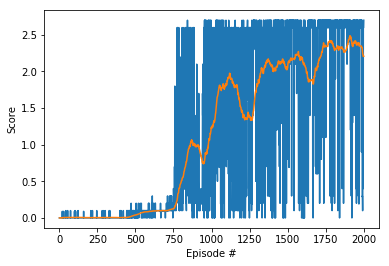

In [12]:
import matplotlib.pyplot as plt

#avg_mask = np.ones(100) / 100
#score_avg= np.convolve(scores, avg_mask, 'valid')

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(max_scores)+1), max_scores)
plt.plot(np.arange(1, len(max_scores)+1), avg_max_scores, label='avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 6. Run the Trained Agent

In [5]:
# Define the agent again. This is not necessary if the entire notebook was run from the beginning.
# However, I had to run this section again and did not want to repeat the learningin in Section 5.

agent = Agent(
    state_size = state_size,
    action_size = action_size,
    num_agents = num_agents,
    random_seed = 19,
    actor_fc1 = 128,
    actor_fc2 = 128,
    critic_fc1 = 128,
    critic_fc2 = 128,
)

In [6]:
load_and_run(agent, env, 'checkpoint_actor_best_avg_max.pth', 'checkpoint_critic_best_avg_max.pth', 100)

Ep 1	Score: 2.60
Ep 2	Score: 2.65
Ep 3	Score: 2.65
Ep 4	Score: 2.60
Ep 5	Score: 2.65
Ep 6	Score: 0.20
Ep 7	Score: 2.55
Ep 8	Score: 2.60
Ep 9	Score: 2.60
Ep 10	Score: 0.25
Ep 11	Score: 2.60
Ep 12	Score: 2.65
Ep 13	Score: 2.65
Ep 14	Score: 2.60
Ep 15	Score: 2.65
Ep 16	Score: 0.10
Ep 17	Score: 2.60
Ep 18	Score: 2.55
Ep 19	Score: 2.65
Ep 20	Score: 2.65
Ep 21	Score: 2.60
Ep 22	Score: 2.65
Ep 23	Score: 2.65
Ep 24	Score: 2.60
Ep 25	Score: 2.65
Ep 26	Score: 2.65
Ep 27	Score: 2.65
Ep 28	Score: 2.60
Ep 29	Score: 2.65
Ep 30	Score: 2.65
Ep 31	Score: 2.60
Ep 32	Score: 2.65
Ep 33	Score: 2.65
Ep 34	Score: 1.25
Ep 35	Score: 0.10
Ep 36	Score: 0.15
Ep 37	Score: 2.60
Ep 38	Score: 0.30
Ep 39	Score: 2.60
Ep 40	Score: 2.65
Ep 41	Score: 2.65
Ep 42	Score: 2.60
Ep 43	Score: 2.65
Ep 44	Score: 2.65
Ep 45	Score: 2.60
Ep 46	Score: 2.65
Ep 47	Score: 2.65
Ep 48	Score: 2.65
Ep 49	Score: 2.60
Ep 50	Score: 0.25
Ep 51	Score: 2.60
Ep 52	Score: 2.65
Ep 53	Score: 2.65
Ep 54	Score: 2.60
Ep 55	Score: 2.65
Ep 56	Score: 1.00
E

In [ ]:
load_and_run(agent, env, 'checkpoint_actor_best_agent_max.pth', 'checkpoint_critic_best_agent_max.pth', 100)

Ep 1	Score: 2.60
Ep 2	Score: 2.65
Ep 3	Score: 2.65
Ep 4	Score: 2.65
Ep 5	Score: 2.65
Ep 6	Score: 2.60
Ep 7	Score: 2.65
Ep 8	Score: 2.65
Ep 9	Score: 2.65
Ep 10	Score: -0.00
Ep 11	Score: 2.60
Ep 12	Score: 2.65
Ep 13	Score: 2.65
Ep 14	Score: 2.65
Ep 15	Score: 2.65
Ep 16	Score: 2.60
Ep 17	Score: 2.65
Ep 18	Score: 2.65
Ep 19	Score: 2.65
Ep 20	Score: 0.05
Ep 21	Score: 2.60
Ep 22	Score: 2.65
Ep 23	Score: 2.65
Ep 24	Score: 2.60
Ep 25	Score: 2.65
Ep 26	Score: 2.65
Ep 27	Score: 2.65
Ep 28	Score: 2.65
Ep 29	Score: 2.65
Ep 30	Score: 0.10
Ep 31	Score: 2.60
Ep 32	Score: 2.65
Ep 33	Score: -0.00
Ep 34	Score: 2.60
Ep 35	Score: 2.65


When finished, you can close the environment.

In [11]:
env.close()